# Plot-Stract

### The goal is to first scrape the information from a png of a frequency plot of a sample set and then check if the set is normally distributed

### This project is not fully annotated

## Scrape Data from PNG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

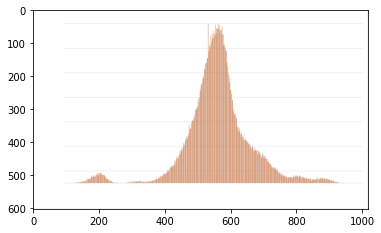

In [2]:
base = cv.imread('base.png')
plt.imshow(base)

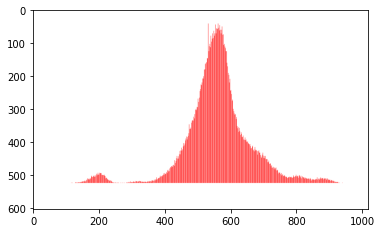

In [3]:
ret, thresh = cv.threshold(base,120,255,cv.THRESH_BINARY)

plt.imshow(thresh)

In [5]:
#go along x-axis to find start pixel (the 2nd and third layers have all the data 255 is white)
#start at bottom left and go across each row until you find a 0
#mark the the first point enter new nested loop
#if we are on a bar -> go up vertically until the point equals zero -> save point into curve array
#(604,1018,3)
#Start y -  524
#Start x -  116

In [6]:
def find_top(vert):
    for i in range(len(vert)):
        if (vert[i]==0)&(vert[i-1]==255):
            return i
        

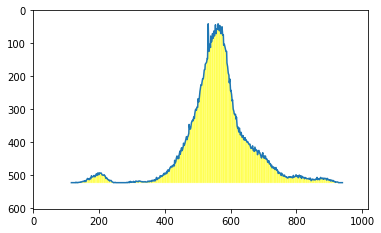

In [7]:
ret, thresh = cv.threshold(base,120,255,cv.THRESH_BINARY)
thresh[:,:,0]=255
thresh[:,:,1]=255
a=0
#find x-axis
for i in range(604):
    if a ==0:
        for j in range(1018):
            if thresh[603-i,j,2]==0:
                starty = 603-i
                a=1
                break
    else:
        break
#get base points
a=0
for i in range(1018):
    if thresh[starty,i,2]==0:
        if a == 0:
            bottom = np.array(i)
            a=1
        else:
            bottom = np.append(bottom,i)
#get top points
a=0
for i in bottom:
    if a==0:
        top = np.array(find_top(thresh[:,i,2]))
        a=1
    else:
        top = np.append(top,find_top(thresh[:,i,2]))
plt.plot(bottom,top)
plt.imshow(thresh)

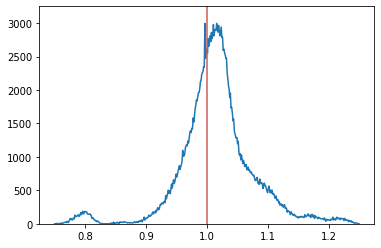

In [8]:
#scale
#max count value/max_arr_value*arr
top_scaled = -1*(3250/np.max(top)*top-3250) #it was upside down bc of the way images are indexed
top_scaled = top_scaled - np.min(top_scaled)
#plt.plot(np.arange(len(top)),top_scaled)
#between every two points add 64 linearly spaced points
a=0

for i in range(len(top_scaled)-1):
    if a==0:
        new = np.array(np.linspace(top_scaled[i],top_scaled[i+1],num=64))
        a=1
    else:
        new = np.append(new,np.linspace(top_scaled[i],top_scaled[i+1],num=64))
newx = np.linspace(0.75,1.25,num=len(new))
plt.plot(newx,new)
plt.vlines(1,0,3250,colors='indianred')
plt.ylim((0,3250));


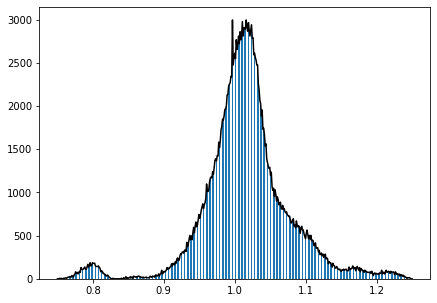

In [9]:
#Recreate initial Plot
w = 0.5/len(top_scaled)*0.5
x = np.linspace(0.75,1.25,num=len(top_scaled))
height = top_scaled
plt.figure(figsize=(7,5))
plt.bar(x,height, width=w)
plt.plot(x,height,'black')
plt.savefig('recreated.png')

## Statistical Analysis

In [20]:
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro, normaltest

In [21]:
#Create data frame for analysis
data = pd.DataFrame(columns=['Value','Frequency'])
data['Value']=x
data['Frequency']=top_scaled.round()
data.head()

,Value,Frequency
0,0.750000,0.0
1,0.751073,0.0
2,0.752146,0.0
3,0.753219,6.0
4,0.754292,0.0


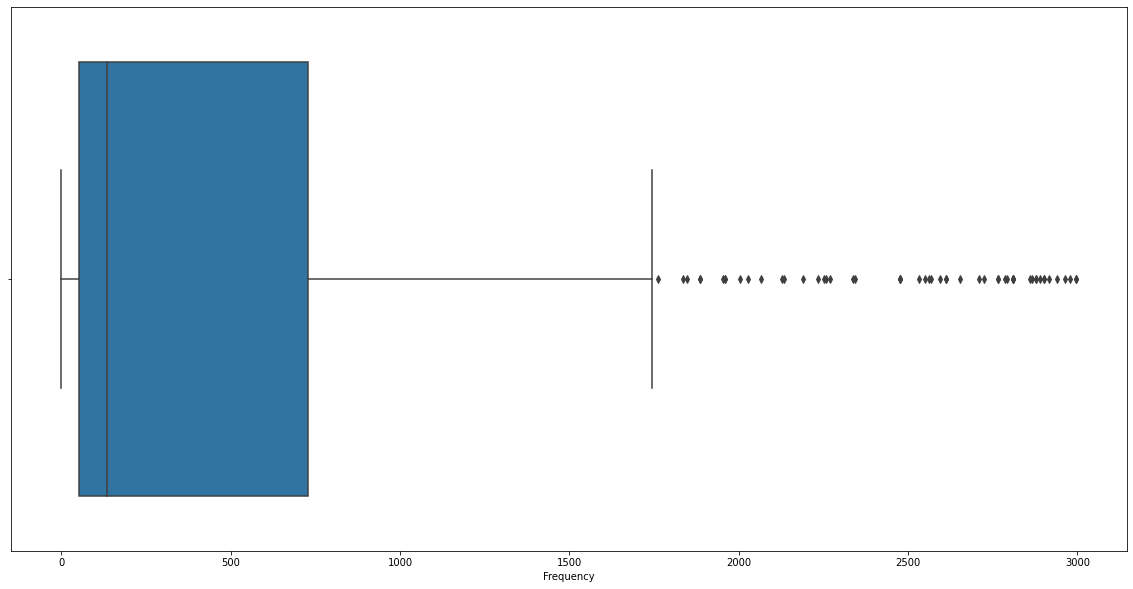

In [22]:
#Create boxplot
plt.figure(figsize=(20,10))
sns.boxplot(data=data,x='Frequency');

In [23]:
#Calculate Z-score for outliers
m = data.Frequency.mean()
stdv = data.Frequency.std()
z=[]
for X in data.Frequency:
    z.append((X-m)/stdv)
data['Zscore']=z
data.head()

,Value,Frequency,Zscore
0,0.750000,0.0,-0.691757
1,0.751073,0.0,-0.691757
2,0.752146,0.0,-0.691757
3,0.753219,6.0,-0.684332
4,0.754292,0.0,-0.691757


In [24]:
#Flag Outliers
flag = []
for z in data.Zscore:
    if (z>=3)or(z<=-3):
        flag.append('Outlier')
    else:
        flag.append('Non-Outlier')
data['Outlier'] = flag
data.loc[data['Outlier']=='Outlier']

,Value,Frequency,Zscore,Outlier
230,0.996781,2996.0,3.016091,Outlier
248,1.016094,2996.0,3.016091,Outlier


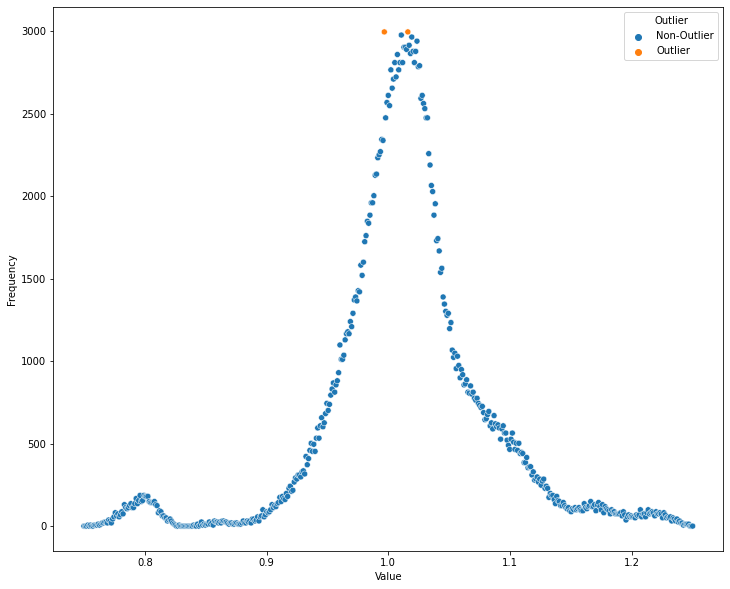

In [25]:
#Visualize
plt.figure(figsize=(12,10))
sns.scatterplot(data=data,x='Value',y='Frequency',
               hue='Outlier');

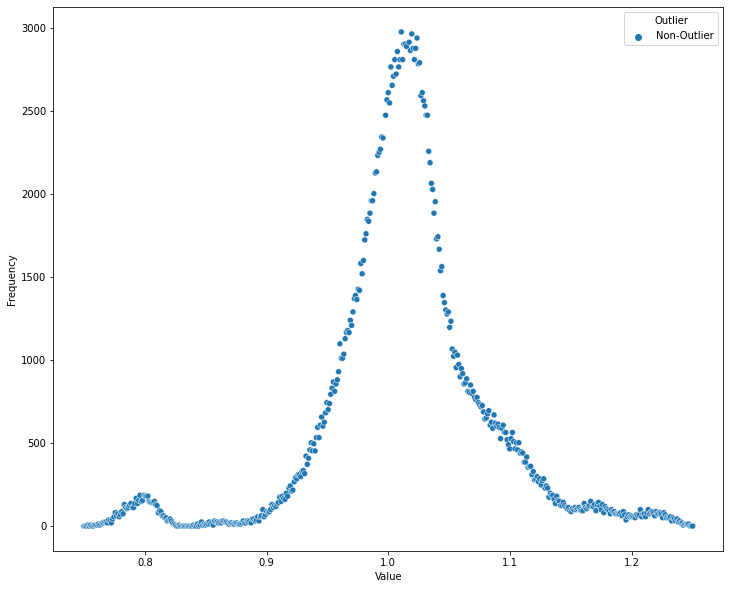

In [26]:
#Remove outliers
cleansed = data.drop([230,248])

#Visualize
plt.figure(figsize=(12,10))
sns.scatterplot(data=cleansed,x='Value',y='Frequency',
               hue='Outlier');

In [27]:
#Create data set
cleansed_set = []

for value in cleansed['Value']:
    for freq in cleansed['Frequency']:
        cleansed_set.append(value)
        
#Statistics
cleansed_df = pd.DataFrame(cleansed_set,columns=['Value'])

cleansed_df.Value.describe()

count    216225.000000
mean          0.999972
std           0.144956
min           0.750000
25%           0.874464
50%           1.000000
75%           1.125536
max           1.250000
Name: Value, dtype: float64

In [37]:
#Kolmogorov–Smirnov Normality Test - Raw Data
stat, p = normaltest(cleansed_df['Value'])
print('p=%.3f' % (p))
if p<0.001:
    print('Sample set is Normal')
else:
    print('Sample set is not Normal')

p=0.000
Sample set is Normal
